In [92]:
import os
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pandas as pd

#Criando as pastas de resultados
output_dirs = {
    "hill_climbing": "resultados/Subida de encosta",
    "simulated_annealing": "resultados/Têmpera Simulada",
    "alg_conj": "resultados/Algoritmos em conjunto",
    "hist": "resultados/Histogramas",
    "dxl": "resultados/DxI",
    "resul": "/resultados"
}

#Verifica se existe os dirs
for directory in output_dirs.values():
  if os.path.exists(directory):
      shutil.rmtree(directory)
  os.makedirs(directory, exist_ok=True)

# Carregar imagem
image_path = "/content/dados.png"
image = cv2.imread(image_path)

# Verificar se a imagem foi carregada corretamente
if image is None:
    raise FileNotFoundError(f"Erro: Não foi possível carregar a imagem em {image_path}")

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Definir intervalo para vermelho
lower_red1 = np.array([0, 120, 100], dtype=np.uint8)
upper_red1 = np.array([10, 255, 255], dtype=np.uint8)
lower_red2 = np.array([170, 120, 100], dtype=np.uint8)
upper_red2 = np.array([180, 255, 255], dtype=np.uint8)

# Criar máscara
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
red_mask = cv2.bitwise_or(mask1, mask2)

# Detectar cidades
contours, _ = cv2.findContours(red_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cities = np.array([cv2.boundingRect(cnt)[:2] for cnt in contours])

if len(cities) == 0:
    raise ValueError("Nenhuma cidade detectada na imagem.")

# Função para calcular a distância total do caminho
def total_distance(cities, path):
    return sum(np.linalg.norm(cities[path[i]] - cities[path[i-1]]) for i in range(len(path)))

In [93]:
# Algoritmo de Subida de Encosta
def hill_climbing(cities, max_iters=1000):
    n = len(cities)
    best_path = list(range(n))
    random.shuffle(best_path)
    best_dist = total_distance(cities, best_path)

    for _ in range(max_iters):
        i, j = sorted(random.sample(range(n), 2))
        new_path = best_path[:i] + best_path[i:j+1][::-1] + best_path[j+1:]
        new_dist = total_distance(cities, new_path)

        if new_dist < best_dist:
            best_path, best_dist = new_path, new_dist

    return best_path, best_dist

In [94]:
# Algoritmo de Têmpera Simulada
def simulated_annealing(cities, initial_temp=100, cooling_rate=0.995, max_iters=10000):
    n = len(cities)
    path = list(range(n))
    random.shuffle(path)
    dist = total_distance(cities, path)
    temp = initial_temp

    for _ in range(max_iters):
        i, j = sorted(random.sample(range(n), 2))
        new_path = path[:i] + path[i:j+1][::-1] + path[j+1:]
        new_dist = total_distance(cities, new_path)

        if new_dist < dist or random.random() < np.exp((dist - new_dist) / temp):
            path, dist = new_path, new_dist

        temp *= cooling_rate
        if temp < 1e-8:
            break

    return path, dist

In [95]:
# Função para plotar e salvar imagem
def plot_and_save(cities, path, title, filename):
    plt.figure(figsize=(8, 6))
    plt.scatter(cities[:, 0], -cities[:, 1], c='red')

    # Corrigir erro de índice fora do intervalo
    ordered_cities = cities[np.append(path, path[0])]
    plt.plot(ordered_cities[:, 0], -ordered_cities[:, 1], 'b-')
    plt.title(title)
    plt.savefig(filename)
    plt.close()

In [96]:
# Salvar resultados
hc_results, sa_results = [], []

In [97]:
# Executar e salvar resultados da Subida de Encosta
for i in range(10):
    hc_path, hc_dist = hill_climbing(cities)
    hc_results.append(hc_dist)
    filename = os.path.join(output_dirs["hill_climbing"], f"hc_result_{i}.png")
    plot_and_save(cities, hc_path, f"Subida de Encosta - Distância: {hc_dist:.2f}", filename)

In [98]:
# Executar e salvar resultados da Têmpera Simulada
for i in range(10):
    sa_path, sa_dist = simulated_annealing(cities)
    sa_results.append(sa_dist)
    filename = os.path.join(output_dirs["simulated_annealing"], f"sa_result_{i}.png")
    plot_and_save(cities, sa_path, f"Têmpera Simulada - Distância: {sa_dist:.2f}", filename)

Comparando os dois

In [99]:
# Criação de uma tabela de comparação
df = pd.DataFrame({
    "Algoritmo": ["Subida de encosta"] * 10 + ["Têmpera Simulada"] * 10,
    "Distância": hc_results + sa_results
})

In [100]:
# Estatísticas
summary = df.groupby("Algoritmo")["Distância"].agg(["mean", "min", "max", "std"])

output_txt = "resultados/estatisticas.txt"

# salva num arquivo de texto
with open(output_txt, "w") as file:
  file.write(summary.to_string())

print("Arquivo salvo!")

Arquivo salvo!


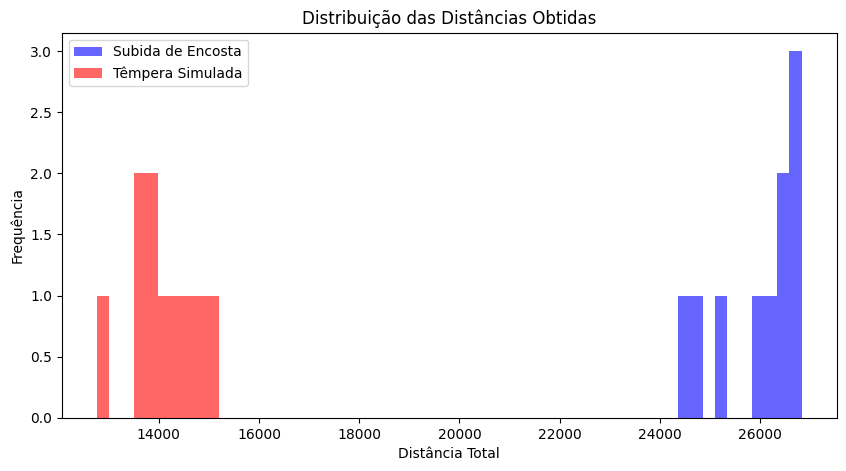

In [101]:
# Criando dir
histogram_comp = "resultados/Histogramas"
os.makedirs(histogram_comp, exist_ok=True)

# Histograma de Comp.
plt.figure(figsize=(10, 5))
plt.hist(hc_results, bins=10, alpha=0.6, label="Subida de Encosta", color="blue")
plt.hist(sa_results, bins=10, alpha=0.6, label="Têmpera Simulada", color="red")
plt.xlabel("Distância Total")
plt.ylabel("Frequência")
plt.title("Distribuição das Distâncias Obtidas")
plt.legend()
filename = os.path.join(histogram_comp, "histograma_comparacao.png")
plt.savefig(filename)

Plotando os dois algoritmos em um único mapa

In [102]:
# Criando dir
together_alg = "resultados/Algoritmos em conjunto"
os.makedirs(together_alg, exist_ok=True)

# Função para plotar os dois algoritmos juntos
def plot_comparison(cities, hc_path, hc_dist, sa_path, sa_dist):
    plt.figure(figsize=(8, 6))

    # Plotar pontos das cidades
    plt.scatter(cities[:, 0], -cities[:, 1], c='black', marker='o', label="Cidades")

    # Traçar caminho da Subida de Encosta (azul)
    ordered_cities_hc = cities[np.append(hc_path, hc_path[0])]
    plt.plot(ordered_cities_hc[:, 0], -ordered_cities_hc[:, 1], 'b-', label=f"Subida de Encosta (Distância: {hc_dist:.2f})")

    # Traçar caminho da Têmpera Simulada (vermelho)
    ordered_cities_sa = cities[np.append(sa_path, sa_path[0])]
    plt.plot(ordered_cities_sa[:, 0], -ordered_cities_sa[:, 1], 'r-', label=f"Têmpera Simulada (Distância: {sa_dist:.2f})")

    plt.legend()
    plt.title("Comparação de Caminhos - Subida de Encosta vs. Têmpera Simulada")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    filename = os.path.join(together_alg, "alg_conjunto.png")
    plt.savefig(filename)

In [103]:
# Executar os algoritmos
hc_path, hc_dist = hill_climbing(cities)
sa_path, sa_dist = simulated_annealing(cities)

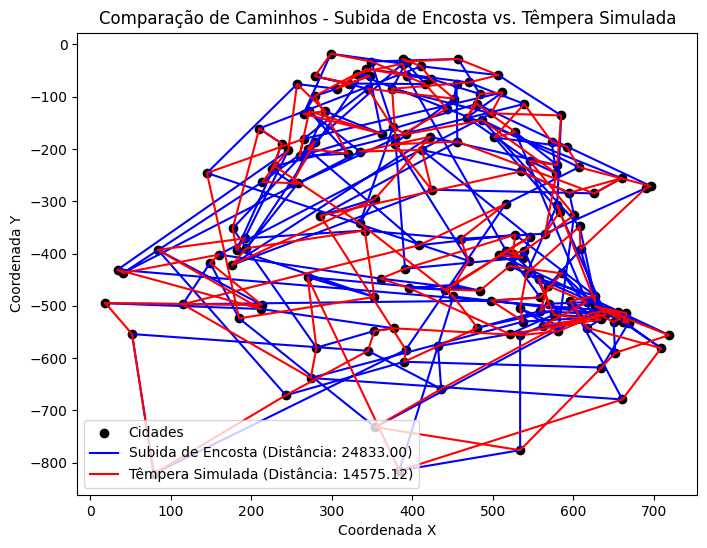

In [104]:
# Plotar a comparação
plot_comparison(cities, hc_path, hc_dist, sa_path, sa_dist)

Distância x Iterações

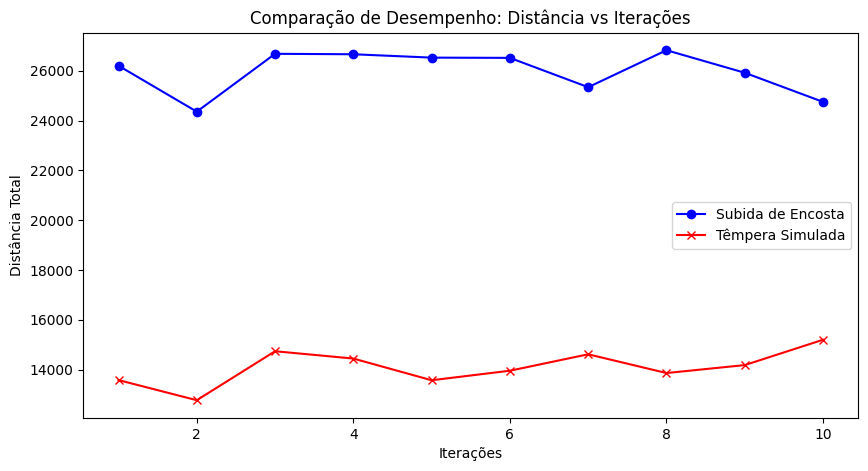

In [105]:
# Criando dir
distance_interations = "resultados/DxI"
os.makedirs(distance_interations, exist_ok=True)

# Gráfico de Comparação de Desempenho
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), hc_results, label="Subida de Encosta", color="blue", marker="o")
plt.plot(range(1, 11), sa_results, label="Têmpera Simulada", color="red", marker="x")
plt.xlabel("Iterações")
plt.ylabel("Distância Total")
plt.title("Comparação de Desempenho: Distância vs Iterações")
plt.legend()
filename = os.path.join(distance_interations, "dxi.png")
plt.savefig(filename)